In [94]:
import datetime as dt  
import pandas as pd
import datetime as dt  		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
import random  		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 	  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
import pandas as pd  		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
import util as ut  	
import QLearner as ql 
import indicators as ind
from marketsimcode import compute_portvals

symbol="JPM" 		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
# sd=dt.datetime(2008, 1, 1)		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
# ed=dt.datetime(2009, 12, 31)  


sd=dt.datetime(2010, 1, 1)		  	   		  	  			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
ed=dt.datetime(2011, 12, 31)  
sv=100000 	

In [95]:
syms = [symbol] 
dates = pd.date_range(sd, ed)  	

In [96]:
prices= ut.get_data(syms, dates)[syms]

In [97]:
volume = ut.get_data(syms, dates, colname='Volume')[syms]
volume = volume.rename(columns={'JPM': 'vol'})

In [98]:
history = dt.timedelta(100)
full_sd = sd - history
df_price_full = ut.get_data([symbol], pd.date_range(full_sd, ed))
df_price_full = df_price_full[syms]
lookback = 60 #3 month trading frequency
shorter_lookback =30

bbp = ind.bbp(sd, ed, shorter_lookback, df_price_full)
sma = ind.price_sma(sd, ed, shorter_lookback, df_price_full)
rsi = ind.rsi(sd, ed, shorter_lookback, df_price_full)
osi = ind.stochastic_osi(sd, ed, shorter_lookback, df_price_full)
chaikin = ind.chaikin(sd, ed, lookback, df_price_full)

In [99]:
observations = pd.concat([prices, bbp, sma, rsi, osi, chaikin, volume], axis=1)

In [100]:
observations.head()

,JPM,bbp,sma,rsi,osi,chaikin,vol
2010-01-04,40.87,0.950661,1.028116,48.361823,78.055556,-0.004301,35460500
2010-01-05,41.67,1.172551,1.047248,54.021352,95.789474,0.020673,41208300
2010-01-06,41.89,1.149924,1.051509,55.077574,95.802469,0.018295,27729000
2010-01-07,42.72,1.272548,1.071008,55.235418,93.503937,0.025887,44864700
2010-01-08,42.62,1.139908,1.066584,57.921887,91.338583,0.029763,33110100


In [101]:
import numpy as np 

In [102]:
period = 2

In [103]:
bbp_thres = [-np.inf,0,1,np.inf]
bbp_signal = pd.DataFrame(pd.cut(observations['bbp'], bins=bbp_thres, labels=[-1,0,1])) 
bbp_signal['rolling']=bbp_signal.rolling(period).sum()
sell_sig_bbp = bbp_signal[(bbp_signal['rolling'] == period-1) & (bbp_signal['bbp'] == 0)]
buy_sig_bbp = bbp_signal[(bbp_signal['rolling'] == -(period-1)) & (bbp_signal['bbp'] == 0)]

In [104]:
buy_sig_bbp.head()

,bbp,rolling
2010-01-25,0,-1.0
2010-01-27,0,-1.0
2010-04-28,0,-1.0
2010-05-10,0,-1.0
2010-05-21,0,-1.0


In [105]:
sell_sig_bbp.head()

,bbp,rolling
2010-01-12,0,1.0
2010-03-08,0,1.0
2010-04-16,0,1.0
2010-07-14,0,1.0
2010-11-08,0,1.0


In [106]:
trading_signals = pd.concat([buy_sig_bbp, sell_sig_bbp]).sort_index()
trading_signals.head()

,bbp,rolling
2010-01-12,0,1.0
2010-01-25,0,-1.0
2010-01-27,0,-1.0
2010-03-08,0,1.0
2010-04-16,0,1.0


Manual Strategy 

Always execute the first signal to get into the market, and do not execute until 3 consecutive reveral signal from current holding position - potentially look into if price movement more than certain range 

In [107]:
df_trade_manual = pd.DataFrame(columns=['Date', 'Symbol', 'Order','Shares'])
df_trade_benchmark= pd.DataFrame(columns=['Date', 'Symbol', 'Order','Shares'])

In [108]:
data = {'Date': observations.index[0], 
        'Symbol': "JPM", 
        'Order':'BUY', 
        'Shares':1000}

df_trade_benchmark = df_trade_benchmark.append(data, ignore_index=True)

In [109]:
for i in range(len(trading_signals)): 

    if i==0: 
        if trading_signals.iloc[i]['rolling'] == -1: 
            order = "BUY"
        else: 
            order = "SELL"
        data = {'Date': trading_signals.index[i], 
                'Symbol': "JPM", 
                'Order':order, 
                'Shares':1000}
        df_trade_manual = df_trade_manual.append(data, ignore_index=True)

    
    else: 
        if trading_signals.iloc[i - 1]['rolling'] != trading_signals.iloc[i]['rolling']: 
            if trading_signals.iloc[i]['rolling'] == -1: 
                order = "BUY"
            else: 
                order = "SELL"
            data = {'Date': trading_signals.index[i], 
                    'Symbol': "JPM", 
                    'Order':order, 
                    'Shares':1000}
            df_trade_manual = df_trade_manual.append(data, ignore_index=True)

In [110]:
df_trade_manual.head()

,Date,Symbol,Order,Shares
0,2010-01-12,JPM,SELL,1000
1,2010-01-25,JPM,BUY,1000
2,2010-03-08,JPM,SELL,1000
3,2010-04-28,JPM,BUY,1000
4,2010-07-14,JPM,SELL,1000


In [111]:
df_trade_benchmark.head()

,Date,Symbol,Order,Shares
0,2010-01-04,JPM,BUY,1000


In [112]:
from marketsim import compute_portvals

In [113]:
manual_strategy_port = compute_portvals(df_trade_manual, start_val=100000, commission=9.95, impact=0.005, start=sd, end=ed)
manual_strategy_port = manual_strategy_port/manual_strategy_port[0]

In [114]:
bench_strategy_port = compute_portvals(df_trade_benchmark, start_val=100000, commission=9.95, impact=0.005, start=sd, end=ed)
bench_strategy_port = bench_strategy_port/bench_strategy_port[0]

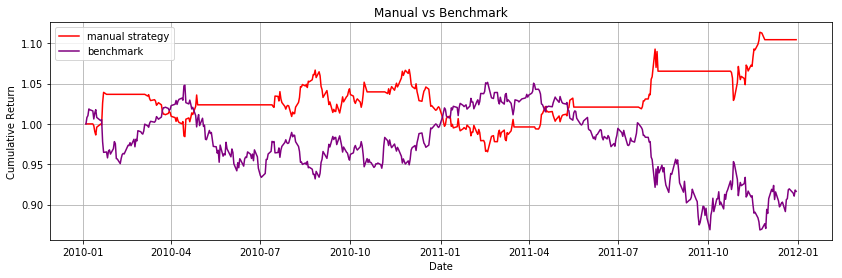

In [115]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(manual_strategy_port, color="red", label="manual strategy")
ax.plot(bench_strategy_port, color="purple", label="benchmark")
ax.set_title("Manual vs Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.legend()
ax.grid(True)
fig.set_figwidth(14)
fig.savefig('plot.png')

In [116]:
rsi_thres = [-np.inf, 30, 70, np.inf]
rsi_signal = pd.DataFrame(pd.cut(observations['rsi'], bins=rsi_thres, labels=[-1,0,1])) 
rsi_signal['rolling']=rsi_signal.rolling(period).sum()
sell_sig_rsi= rsi_signal[(rsi_signal['rolling'] == period-1) & (rsi_signal['rsi'] == 0)]
buy_sig_rsi = rsi_signal[(rsi_signal['rolling'] == -(period-1)) & (rsi_signal['rsi'] == 0)]

In [117]:
sma_thres = [-np.inf, 0.9, 1.1, np.inf]
sma_signal = pd.DataFrame(pd.cut(observations['sma'], bins=sma_thres, labels=[-1,0,1])) 
sma_signal['rolling']=sma_signal.rolling(period).sum()
sell_sig_sma= sma_signal[(sma_signal['rolling'] == period-1) & (sma_signal['sma'] == 0)]
buy_sig_sma = sma_signal[(sma_signal['rolling'] == -(period-1)) & (sma_signal['sma'] == 0)]

In [118]:
osi_thres = [-np.inf, 20, 80, np.inf]
osi_signal = pd.DataFrame(pd.cut(observations['osi'], bins=osi_thres, labels=[-1,0,1])) 
osi_signal['rolling']=osi_signal.rolling(period).sum()
sell_sig_osi= osi_signal[(osi_signal['rolling'] == period-1) & (osi_signal['osi'] == 0)]
buy_sig_osi = osi_signal[(osi_signal['rolling'] == -(period-1)) & (osi_signal['osi'] == 0)]

In [119]:
chaikin_thres = [-np.inf, -0.2, 0.2, np.inf]
chaikin_signal = pd.DataFrame(pd.cut(observations['chaikin'], bins=chaikin_thres, labels=[-1,0,1])) 
chaikin_signal['rolling']=chaikin_signal.rolling(period).sum()
sell_sig_chaikin= chaikin_signal[(chaikin_signal['rolling'] == period-1) & (chaikin_signal['chaikin'] == 0)]
buy_sig_chaikin = chaikin_signal[(chaikin_signal['rolling'] == -(period-1)) & (chaikin_signal['chaikin'] == 0)]

In [120]:
import matplotlib.pyplot as plt

In [121]:
buy_dates = list(set(np.concatenate((
                buy_sig_sma.index.values,
                ))))

sell_dates = list(set(np.concatenate((
                 sell_sig_sma.index.values,
                ))))

In [122]:
distribution = observations.describe()

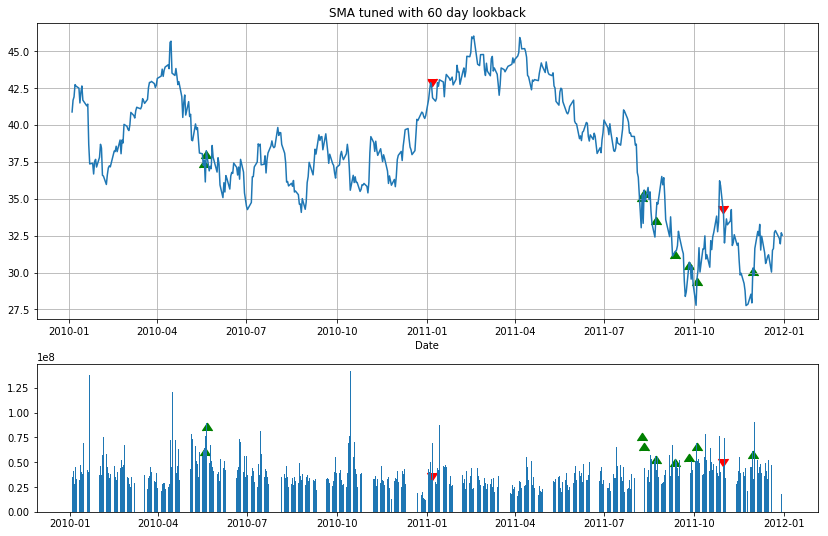

In [124]:
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
fig.set_figwidth(14)
fig.set_figheight(9)
ax[0].plot(observations['JPM'])
ax[0].set_xlabel("Date")
ax[0].grid(True)
ax[0].set_title('SMA tuned with 60 day lookback')

ax[1].bar(observations.index, height = observations['vol'])

for idx in buy_dates:
    ax[0].scatter(idx, observations['JPM'][idx], marker=6, s=100, c='green')
    ax[1].scatter(idx, observations['vol'][idx], marker=6, s=100, c='green')

for idx in sell_dates: 
    ax[0].scatter(idx, observations['JPM'][idx], marker=7, s=100, c='red')
    ax[1].scatter(idx, observations['vol'][idx], marker=7, s=100, c='red')

In [180]:
distribution

,JPM,bbp,sma,rsi,osi,chaikin,vol
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,5.050000e+02
mean,35.282297,0.483653,1.000960,49.029996,49.719048,0.007242,5.636468e+07
std,6.422781,0.303308,0.076678,13.598519,30.100171,0.140966,3.248318e+07
min,15.080000,-0.215305,0.662792,15.551020,0.000000,-0.428628,7.956500e+06
25%,31.860000,0.250275,0.960345,38.509804,22.229340,-0.089546,3.287820e+07
50%,36.640000,0.481921,0.997370,49.444444,50.143266,0.018647,4.570190e+07
75%,40.160000,0.726627,1.038632,58.970100,76.790672,0.097827,6.931670e+07
max,46.710000,1.245099,1.316317,89.675516,100.000000,0.341154,1.940750e+08


In [188]:
distribution['vol']['25%']

32878200.0

In [54]:
def get_bin(indicator): 
    bins= [distribution.loc['min', indicator],
           distribution.loc['25%', indicator],
           distribution.loc['50%', indicator],
           distribution.loc['75%', indicator],
           distribution.loc['max', indicator]]
    return bins

In [55]:
for i in distribution.columns:
    df_discrete = pd.DataFrame(pd.cut(observations[i], bins=get_bin(i), labels=[1,2,3,4])) 
    observations = observations.join(df_discrete, rsuffix='_discrete')
   

In [29]:
import importlib
importlib.reload(ManualStrategy)

<module 'ManualStrategy' from '/Users/Ally.Zhang/Documents/VS Code/ML4T/strategy_evaluation/ManualStrategy.py'>

In [30]:
import ManualStrategy
import datetime as dt

In [31]:
a, b = ManualStrategy.testPolicy(symbol="JPM", sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009, 12, 31), sv=100000)

In [32]:
ManualStrategy.generate_trade(a, 'JPM')

,Date,Symbol,Order,Shares
0,2008-01-09,JPM,BUY,1000
1,2008-01-30,JPM,SELL,1000
2,2008-03-11,JPM,BUY,1000
3,2008-04-02,JPM,SELL,1000
4,2008-06-13,JPM,BUY,1000
5,2008-09-22,JPM,SELL,1000
6,2008-10-28,JPM,BUY,1000
7,2009-03-19,JPM,SELL,1000


In [33]:
b

,Date,Symbol,Order,Shares
0,2008-01-09,JPM,BUY,1000
1,2008-01-30,JPM,SELL,1000
2,2008-03-11,JPM,BUY,1000
3,2008-04-02,JPM,SELL,1000
4,2008-06-13,JPM,BUY,1000
5,2008-09-22,JPM,SELL,1000
6,2008-10-28,JPM,BUY,1000
7,2009-03-19,JPM,SELL,1000


In [23]:
df_trade_manual = pd.DataFrame(columns=['Date', 'Symbol', 'Order','Shares'])

trading_signals = a
symbol = 'JPM'

for i in range(len(trading_signals)): 

    if i==0: 
        if trading_signals.iloc[i]['rolling'] == -1: 
            order = "BUY"
        else: 
            order = "SELL"
        data = {'Date': trading_signals.index[i], 
                'Symbol': symbol, 
                'Order':order, 
                'Shares':1000}
        df_trade_manual = df_trade_manual.append(data, ignore_index=True)

    
    else: 
        if trading_signals.iloc[i - 1]['rolling'] != trading_signals.iloc[i]['rolling']: 
            if trading_signals.iloc[i]['rolling'] == -1: 
                order = "BUY"
            else: 
                order = "SELL"
            data = {'Date': trading_signals.index[i], 
                    'Symbol': symbol, 
                    'Order':order, 
                    'Shares':1000}
            df_trade_manual = df_trade_manual.append(data, ignore_index=True)



In [24]:
df_trade_manual

,Date,Symbol,Order,Shares
0,2008-01-09,JPM,BUY,1000
1,2008-01-30,JPM,SELL,1000
2,2008-03-11,JPM,BUY,1000
3,2008-04-02,JPM,SELL,1000
4,2008-06-13,JPM,BUY,1000
5,2008-09-22,JPM,SELL,1000
6,2008-10-28,JPM,BUY,1000
7,2009-03-19,JPM,SELL,1000


In [25]:
a

,bbp,rolling,rsi,sma
2008-01-09,0,-1.0,NaN,NaN
2008-01-16,0,-1.0,NaN,NaN
2008-01-30,NaN,1.0,NaN,0
2008-02-04,NaN,1.0,NaN,0
2008-02-04,0,1.0,NaN,NaN
2008-03-11,0,-1.0,NaN,NaN
2008-03-11,NaN,-1.0,NaN,0
2008-03-17,0,-1.0,NaN,NaN
2008-03-17,NaN,-1.0,NaN,0
2008-04-02,NaN,1.0,NaN,0
